In [33]:
import time
import math
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from datetime import datetime, timedelta
from math import sqrt
from pickle import dump, load
from joblib import dump
!pip install tweepy
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout, ELU, ReLU
from tensorflow.keras import Sequential
from tensorflow.keras.losses import mean_squared_error
from tensorflow.python.client import device_lib
import xgboost as xgb
import warnings
from collections import deque
warnings.filterwarnings("ignore")
!pip install pandas_ta
import requests
from pytz import timezone
import pandas_ta as ta
!pip install arch
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import ParameterGrid
"""
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
"""
from datetime import datetime, timedelta
from pandas.plotting import autocorrelation_plot  # Import autocorrelation plot
from statsmodels.stats.outliers_influence import variance_inflation_factor

**Importing Data , Making Indicators**

In [5]:
# Constants for market hours in Eastern Time
MARKET_OPEN = '09:30:00'
MARKET_CLOSE = '16:00:00'
EST = timezone('US/Eastern')

# Function to convert UTC to EST and filter trading hours
def filter_trading_hours(data):
    filtered_data = {}
    for time, values in data.items():
        utc_time = datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
        est_time = utc_time.astimezone(EST).strftime('%Y-%m-%d %H:%M:%S')
        if MARKET_OPEN <= est_time.split()[1] <= MARKET_CLOSE:
            filtered_data[est_time] = values
    return filtered_data

# Function to fetch stock data from Alpha Vantage
def fetch_stock_data(symbol, api_key, start_date, end_date):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=1min&apikey={api_key}&outputsize=full"
    response = requests.get(url)
    data = response.json()
    time_series = data.get("Time Series (1min)", {})
    filtered_data = filter_trading_hours(time_series)
    return {time: {**values, 'symbol': symbol} for time, values in filtered_data.items() if start_date <= time <= end_date}


# Calculate technical indicators
def calculate_indicators(df):
    df = df.sort_index()
    df['RSI'] = ta.rsi(df['close'])
    #df['VWAP'] = ta.vwap(df['high'], df['low'], df['close'], df['volume'])
    macd = ta.macd(df['close'])
    df['MACD'], df['MACD_Hist'], df['MACD_Signal'] = macd['MACD_12_26_9'], macd['MACDh_12_26_9'], macd['MACDs_12_26_9']
    bbands = ta.bbands(df['close'])
    df['BB_Lower'], df['BB_Middle'], df['BB_Upper'] = bbands['BBL_5_2.0'], bbands['BBM_5_2.0'], bbands['BBU_5_2.0']
    kc = ta.kc(df['high'], df['low'], df['close'])
    df = df.join(kc)
    df['EMA_12'], df['EMA_26'] = ta.ema(df['close'], length=12), ta.ema(df['close'], length=26)
    stoch = ta.stoch(df['high'], df['low'], df['close'])
    df['Stoch_K'], df['Stoch_D'] = stoch['STOCHk_14_3_3'], stoch['STOCHd_14_3_3']
    df['ATR'] = ta.atr(df['high'], df['low'], df['close'])
    # Average Directional Index
    adx = ta.adx(df['high'], df['low'], df['close'])
    df['ADX'] = adx['ADX_14']

    # Momentum
    df['Momentum'] = ta.mom(df['close'], length=10)

    # Drop rows with NaN values
    df.dropna(inplace=True)

    return df
# Function to generate signals for technical indicators
def generate_signals(df):
    # RSI signals
    df['RSI_Signal_Buy'] = (df['RSI'] < 30).astype(int)
    df['RSI_Signal_Sell'] = (df['RSI'] > 70).astype(int)

    # MACD signals
    df['MACD_Signal_Buy'] = ((df['MACD'] > df['MACD_Signal']) & (df['MACD'].shift(1) <= df['MACD_Signal'].shift(1))).astype(int)
    df['MACD_Signal_Sell'] = ((df['MACD'] < df['MACD_Signal']) & (df['MACD'].shift(1) >= df['MACD_Signal'].shift(1))).astype(int)

    # Bollinger Bands signals
    df['BB_Signal_Buy'] = (df['close'] < df['BB_Lower']).astype(int)
    df['BB_Signal_Sell'] = (df['close'] > df['BB_Upper']).astype(int)

    # Keltner Channel signals
    df['KC_Signal_Buy'] = (df['close'] < df['KCLe_20_2']).astype(int)
    df['KC_Signal_Sell'] = (df['close'] > df['KCUe_20_2']).astype(int)

    # Stochastic Oscillator signals
    df['Stoch_Signal_Buy'] = ((df['Stoch_K'] < 20) & (df['Stoch_D'] < 20)).astype(int)
    df['Stoch_Signal_Sell'] = ((df['Stoch_K'] > 80) & (df['Stoch_D'] > 80)).astype(int)

    # EMA signals
    df['EMA_Signal_Buy'] = (df['close'] > df['EMA_12']) & (df['close'] > df['EMA_26']).astype(int)
    df['EMA_Signal_Sell'] = (df['close'] < df['EMA_12']) & (df['close'] < df['EMA_26']).astype(int)


    return df

# Read Excel file to get ticker symbols
def read_excel(file_path):
    df = pd.read_excel(file_path)
    return df['Ticker'].tolist()

# Main script
def main():
    api_key = '....'
    file_path = 'holdings-daily-us-en-spy (2).xlsx'
    tickers = read_excel(file_path)

    end_date = datetime.now()
    start_date = end_date - timedelta(days=60)

    all_data = []
    for ticker in tickers:
        data = fetch_stock_data(ticker, api_key, start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d"))
        ticker_df = pd.DataFrame.from_dict(data, orient='index')
        ticker_df = ticker_df.apply(pd.to_numeric, errors='ignore')
        ticker_df['symbol'] = ticker  # Add ticker symbol to the DataFrame
        all_data.append(ticker_df)

    combined_data = pd.concat(all_data)
    combined_data.index = pd.to_datetime(combined_data.index)
    combined_data.rename(columns={
        '1. open': 'open',
        '2. high': 'high',
        '3. low': 'low',
        '4. close': 'close',
        '5. volume': 'volume'
    }, inplace=True)

    # Process and display basic information
    process_and_display_basic_info(combined_data)

    # Calculate technical indicators and create final DataFrame
    combined_data_with_indicators = combined_data.groupby('symbol').apply(calculate_indicators)
    combined_data_with_indicators.reset_index(drop=True, inplace=True)
    combined_data_with_indicators.to_csv('stock_data_with_indicators.csv')

    return combined_data_with_indicators


def process_and_display_basic_info(df):
    earliest_date = df.index.min()
    latest_date = df.index.max()
    print("Earliest Date:", earliest_date)
    print("Latest Date:", latest_date)

    nan_count = df.isna().sum()
    print("NaN Counts per Column:", nan_count)



combined_data_with_indicators = main()

# Apply the signal generation function
combined_data_with_signals = generate_signals(combined_data_with_indicators)
combined_data_with_signals.reset_index(drop=True, inplace=True)
# Rename potential conflicting columns
combined_data_with_signals.rename(columns={'KCLe_20_2': 'KCLe_20_2_old', 'KCBe_20_2': 'KCBe_20_2_old', 'KCUe_20_2': 'KCUe_20_2_old'}, inplace=True)
# Then proceed with your calculations
combined_data_with_indicators = calculate_indicators(combined_data_with_signals)

Earliest Date: 2023-11-24 09:30:00
Latest Date: 2023-12-15 15:00:00
NaN Counts per Column: open      0
high      0
low       0
close     0
volume    0
symbol    0
dtype: int64


In [6]:
combined_data_with_signals.head()

,open,high,low,close,volume,symbol,RSI,MACD,MACD_Hist,MACD_Signal,...,MACD_Signal_Buy,MACD_Signal_Sell,BB_Signal_Buy,BB_Signal_Sell,KC_Signal_Buy,KC_Signal_Sell,Stoch_Signal_Buy,Stoch_Signal_Sell,EMA_Signal_Buy,EMA_Signal_Sell
0,125.240,125.24,125.215,125.230,2101.0,A,34.817791,-0.183684,0.036939,-0.220623,...,0,0,0,0,0,0,1,0,False,True
1,125.220,125.23,125.220,125.225,2073.0,A,34.579283,-0.175299,0.036260,-0.211558,...,0,0,0,0,0,0,1,0,False,True
2,125.225,125.25,125.210,125.250,2757.0,A,36.906520,-0.164737,0.037457,-0.202194,...,0,0,0,0,0,0,1,0,False,True
3,125.250,125.25,125.210,125.240,1549.0,A,36.349503,-0.155382,0.037449,-0.192832,...,0,0,0,0,0,0,1,0,False,True
4,125.250,125.28,125.245,125.245,5678.0,A,36.862608,-0.145884,0.037558,-0.183442,...,0,0,0,0,0,0,0,0,False,True


In [7]:
combined_data_with_signals.columns

Index(['open', 'high', 'low', 'close', 'volume', 'symbol', 'RSI', 'MACD',
       'MACD_Hist', 'MACD_Signal', 'BB_Lower', 'BB_Middle', 'BB_Upper',
       'KCLe_20_2_old', 'KCBe_20_2_old', 'KCUe_20_2_old', 'EMA_12', 'EMA_26',
       'Stoch_K', 'Stoch_D', 'ATR', 'ADX', 'Momentum', 'RSI_Signal_Buy',
       'RSI_Signal_Sell', 'MACD_Signal_Buy', 'MACD_Signal_Sell',
       'BB_Signal_Buy', 'BB_Signal_Sell', 'KC_Signal_Buy', 'KC_Signal_Sell',
       'Stoch_Signal_Buy', 'Stoch_Signal_Sell', 'EMA_Signal_Buy',
       'EMA_Signal_Sell'],
      dtype='object')

In [8]:
combined_data_with_signals.reset_index(drop=True, inplace=True)
combined_data_with_signals.head()

,open,high,low,close,volume,symbol,RSI,MACD,MACD_Hist,MACD_Signal,...,MACD_Signal_Buy,MACD_Signal_Sell,BB_Signal_Buy,BB_Signal_Sell,KC_Signal_Buy,KC_Signal_Sell,Stoch_Signal_Buy,Stoch_Signal_Sell,EMA_Signal_Buy,EMA_Signal_Sell
0,125.240,125.24,125.215,125.230,2101.0,A,34.817791,-0.183684,0.036939,-0.220623,...,0,0,0,0,0,0,1,0,False,True
1,125.220,125.23,125.220,125.225,2073.0,A,34.579283,-0.175299,0.036260,-0.211558,...,0,0,0,0,0,0,1,0,False,True
2,125.225,125.25,125.210,125.250,2757.0,A,36.906520,-0.164737,0.037457,-0.202194,...,0,0,0,0,0,0,1,0,False,True
3,125.250,125.25,125.210,125.240,1549.0,A,36.349503,-0.155382,0.037449,-0.192832,...,0,0,0,0,0,0,1,0,False,True
4,125.250,125.28,125.245,125.245,5678.0,A,36.862608,-0.145884,0.037558,-0.183442,...,0,0,0,0,0,0,0,0,False,True


In [9]:
combined_data_with_signals.head()

,open,high,low,close,volume,symbol,RSI,MACD,MACD_Hist,MACD_Signal,...,MACD_Signal_Buy,MACD_Signal_Sell,BB_Signal_Buy,BB_Signal_Sell,KC_Signal_Buy,KC_Signal_Sell,Stoch_Signal_Buy,Stoch_Signal_Sell,EMA_Signal_Buy,EMA_Signal_Sell
0,125.240,125.24,125.215,125.230,2101.0,A,34.817791,-0.183684,0.036939,-0.220623,...,0,0,0,0,0,0,1,0,False,True
1,125.220,125.23,125.220,125.225,2073.0,A,34.579283,-0.175299,0.036260,-0.211558,...,0,0,0,0,0,0,1,0,False,True
2,125.225,125.25,125.210,125.250,2757.0,A,36.906520,-0.164737,0.037457,-0.202194,...,0,0,0,0,0,0,1,0,False,True
3,125.250,125.25,125.210,125.240,1549.0,A,36.349503,-0.155382,0.037449,-0.192832,...,0,0,0,0,0,0,1,0,False,True
4,125.250,125.28,125.245,125.245,5678.0,A,36.862608,-0.145884,0.037558,-0.183442,...,0,0,0,0,0,0,0,0,False,True


**Plot Technical Indicators**

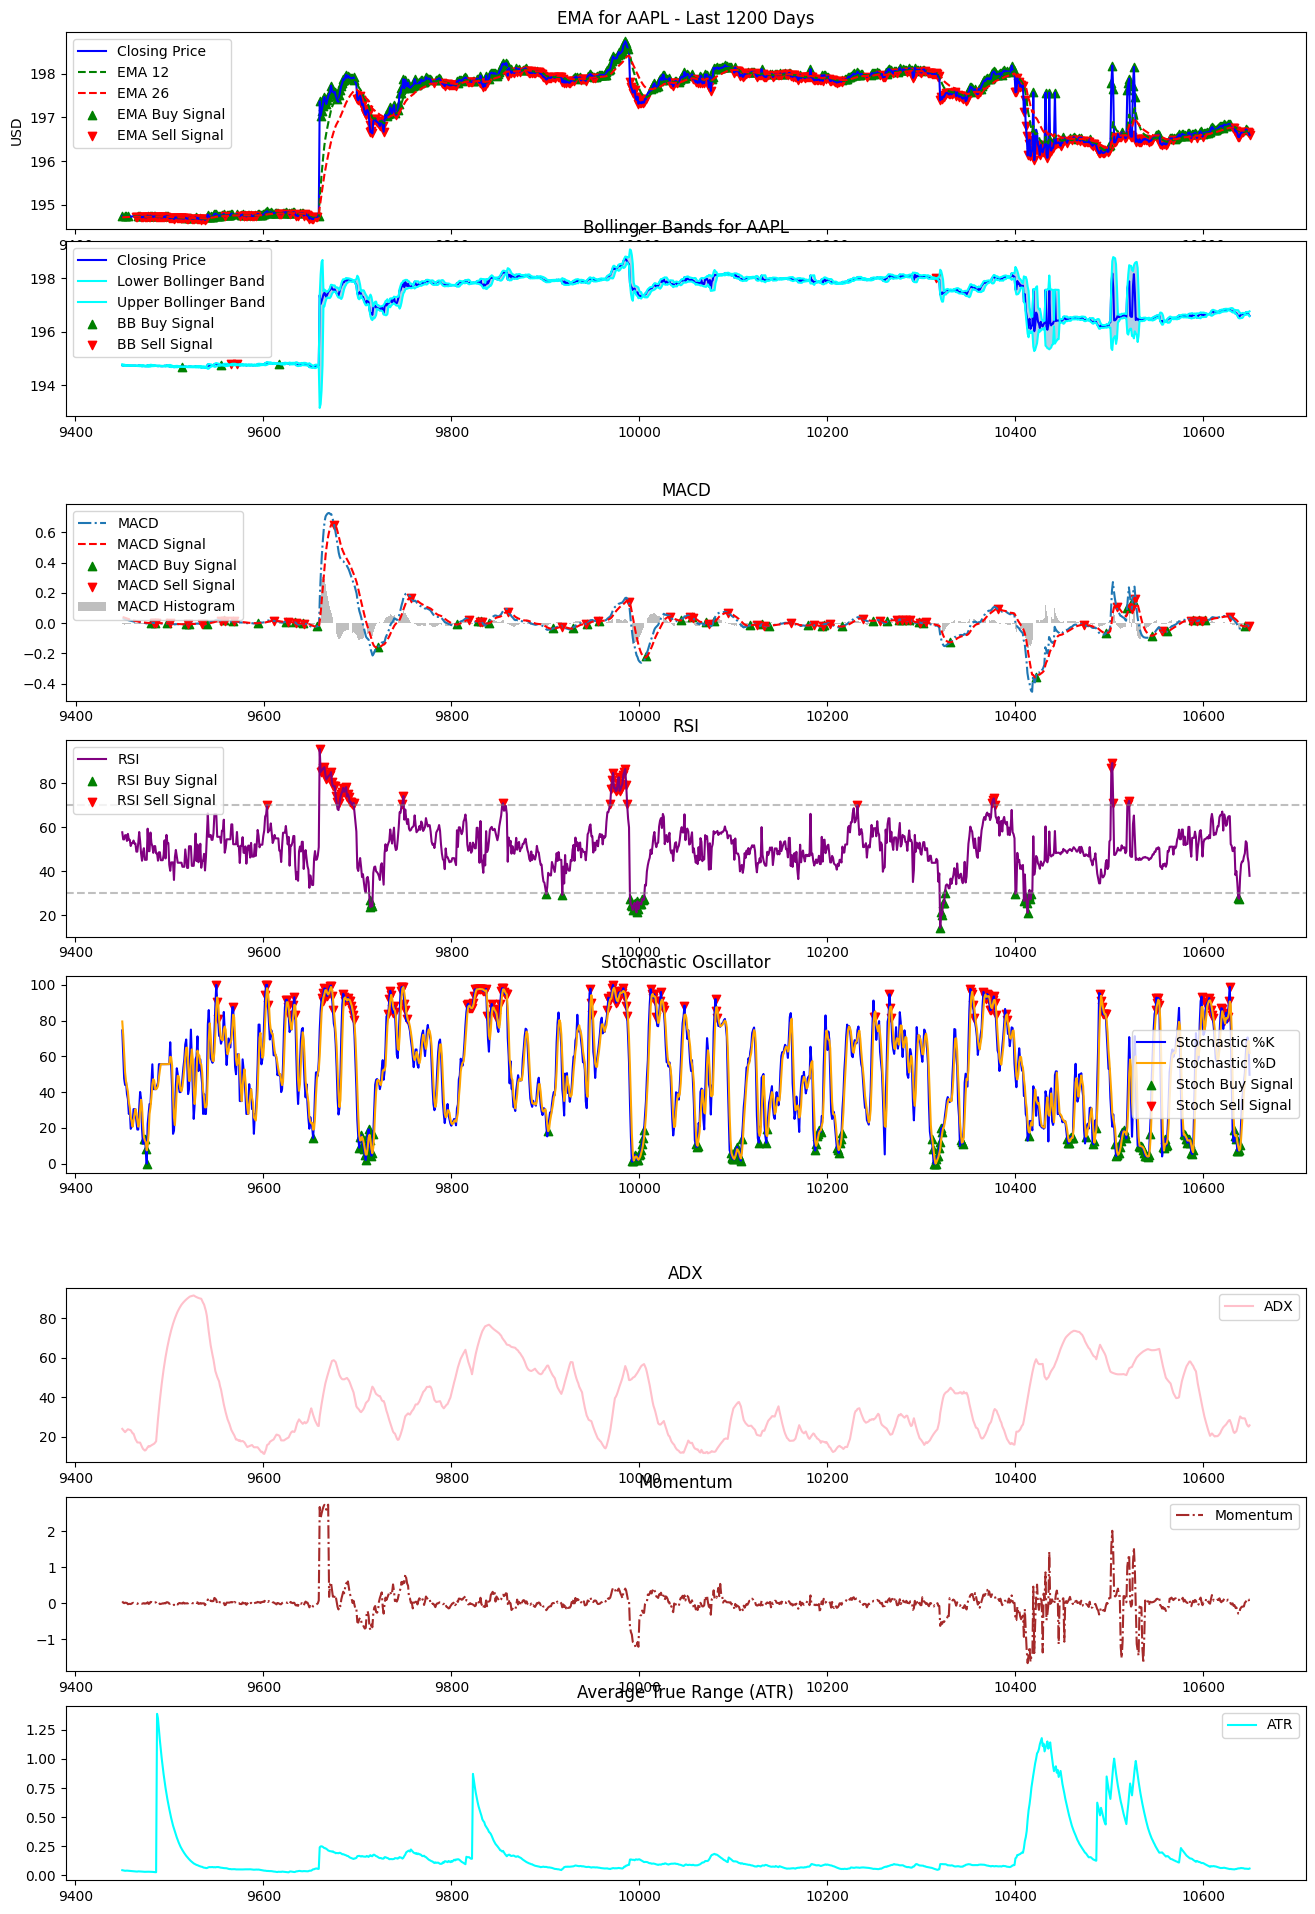

In [10]:
import matplotlib.pyplot as plt

def plot_technical_indicators(dataset, ticker, last_days):
    # Filter dataset for the selected ticker
    dataset = dataset[dataset['symbol'] == ticker]
    dataset = dataset[-last_days:]
    x_ = dataset.index

    plt.figure(figsize=(16, 24), dpi=100)

    # Plot 1: Closing Price and EMA indicators
    plt.subplot(8, 1, 1)
    plt.plot(dataset['close'], label='Closing Price', color='blue')
    plt.plot(dataset['EMA_12'], label='EMA 12', color='green', linestyle='--')
    plt.plot(dataset['EMA_26'], label='EMA 26', color='red', linestyle='--')
    plt.scatter(dataset.index[dataset['EMA_Signal_Buy'] == 1], dataset['close'][dataset['EMA_Signal_Buy'] == 1], marker='^', color='green', label='EMA Buy Signal', alpha=1)
    plt.scatter(dataset.index[dataset['EMA_Signal_Sell'] == 1], dataset['close'][dataset['EMA_Signal_Sell'] == 1], marker='v', color='red', label='EMA Sell Signal', alpha=1)
    plt.title(f'EMA for {ticker} - Last {last_days} Days')
    plt.ylabel('USD')
    plt.legend()

    # Plot 2: Closing Price and Bollinger Bands
    plt.subplot(9, 1, 2)
    plt.plot(dataset['close'], label='Closing Price', color='blue')
    plt.plot(dataset['BB_Lower'], label='Lower Bollinger Band', color='cyan')
    plt.plot(dataset['BB_Upper'], label='Upper Bollinger Band', color='cyan')
    plt.fill_between(x_, dataset['BB_Lower'], dataset['BB_Upper'], alpha=0.35)
    plt.scatter(x_, dataset['close'].where(dataset['BB_Signal_Buy'] == 1), marker='^', color='green', label='BB Buy Signal', alpha=1)
    plt.scatter(x_, dataset['close'].where(dataset['BB_Signal_Sell'] == 1), marker='v', color='red', label='BB Sell Signal', alpha=1)
    plt.title(f'Bollinger Bands for {ticker}')
    plt.legend()


    # Plot 3: MACD, MACD Signal, and MACD Histogram
    plt.subplot(8, 1, 3)
    plt.plot(dataset['MACD'], label='MACD', linestyle='-.')
    plt.bar(x_, dataset['MACD_Hist'], label='MACD Histogram', color='grey', alpha=0.5)
    plt.plot(dataset['MACD_Signal'], label='MACD Signal', color='red', linestyle='--')
    plt.scatter(x_, dataset['MACD'].where(dataset['MACD_Signal_Buy'] == 1), marker='^', color='green', label='MACD Buy Signal', alpha=1)
    plt.scatter(x_, dataset['MACD'].where(dataset['MACD_Signal_Sell'] == 1), marker='v', color='red', label='MACD Sell Signal', alpha=1)
    plt.title('MACD')
    plt.legend()

    # Plot 4: RSI and thresholds
    plt.subplot(8, 1, 4)
    plt.plot(dataset['RSI'], label='RSI', color='purple')
    plt.axhline(30, linestyle='--', color='grey', alpha=0.5)
    plt.axhline(70, linestyle='--', color='grey', alpha=0.5)
    plt.scatter(x_, dataset['RSI'].where(dataset['RSI_Signal_Buy'] == 1), marker='^', color='green', label='RSI Buy Signal', alpha=1)
    plt.scatter(x_, dataset['RSI'].where(dataset['RSI_Signal_Sell'] == 1), marker='v', color='red', label='RSI Sell Signal', alpha=1)
    plt.title('RSI')
    plt.legend()

    # Plot 5: Stochastic Oscillator
    plt.subplot(8, 1, 5)
    plt.plot(dataset['Stoch_K'], label='Stochastic %K', color='blue')
    plt.plot(dataset['Stoch_D'], label='Stochastic %D', color='orange')
    plt.scatter(x_, dataset['Stoch_K'].where(dataset['Stoch_Signal_Buy'] == 1), marker='^', color='green', label='Stoch Buy Signal', alpha=1)
    plt.scatter(x_, dataset['Stoch_K'].where(dataset['Stoch_Signal_Sell'] == 1), marker='v', color='red', label='Stoch Sell Signal', alpha=1)
    plt.title('Stochastic Oscillator')
    plt.legend()

    # Plot 6: Keltner Channels
    plt.subplot(8, 1, 6)
    plt.plot(dataset['KCUe_20_2_old'], label='Upper Keltner Channel', color='red', linestyle='--')
    plt.plot(dataset['KCLe_20_2_old'], label='Lower Keltner Channel', color='green', linestyle='--')
    plt.plot(dataset['close'], label='Closing Price', color='blue')
    plt.scatter(x_, dataset['close'].where(dataset['KC_Signal_Buy'] == 1), marker='^', color='green', label='KC Buy Signal', alpha=1)
    plt.scatter(x_, dataset['close'].where(dataset['KC_Signal_Sell'] == 1), marker='v', color='red', label='KC Sell Signal', alpha=1)
    plt.title('Keltner Channels')
    plt.legend()

    # Plot 7: ADX
    plt.subplot(9, 1, 7)
    plt.plot(dataset['ADX'], label='ADX', color='pink', linestyle='-')
    plt.title('ADX')
    plt.legend()

    # Plot 8: Momentum
    plt.subplot(9, 1, 8)
    plt.plot(dataset['Momentum'], label='Momentum', color='brown', linestyle='-.')
    plt.title('Momentum')
    plt.legend()

    # Plot 9: ATR
    plt.subplot(9, 1, 9)
    plt.plot(dataset['ATR'], label='ATR', color='cyan')
    plt.title('Average True Range (ATR)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_technical_indicators(combined_data_with_signals, 'AAPL', 1200)


**Plot and Calculate Fourier Transformation**

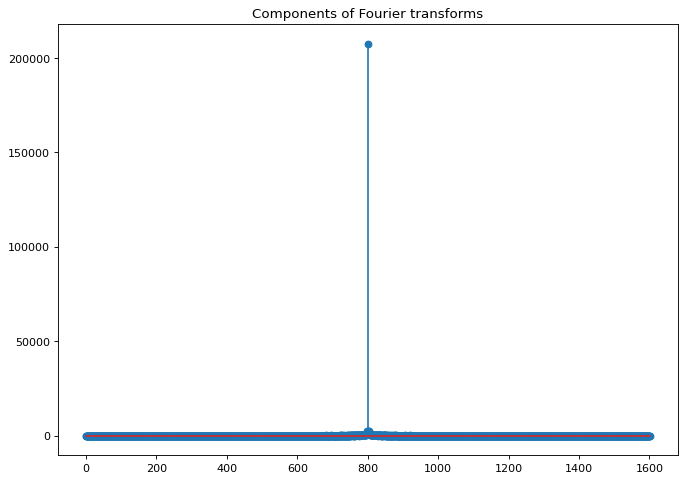

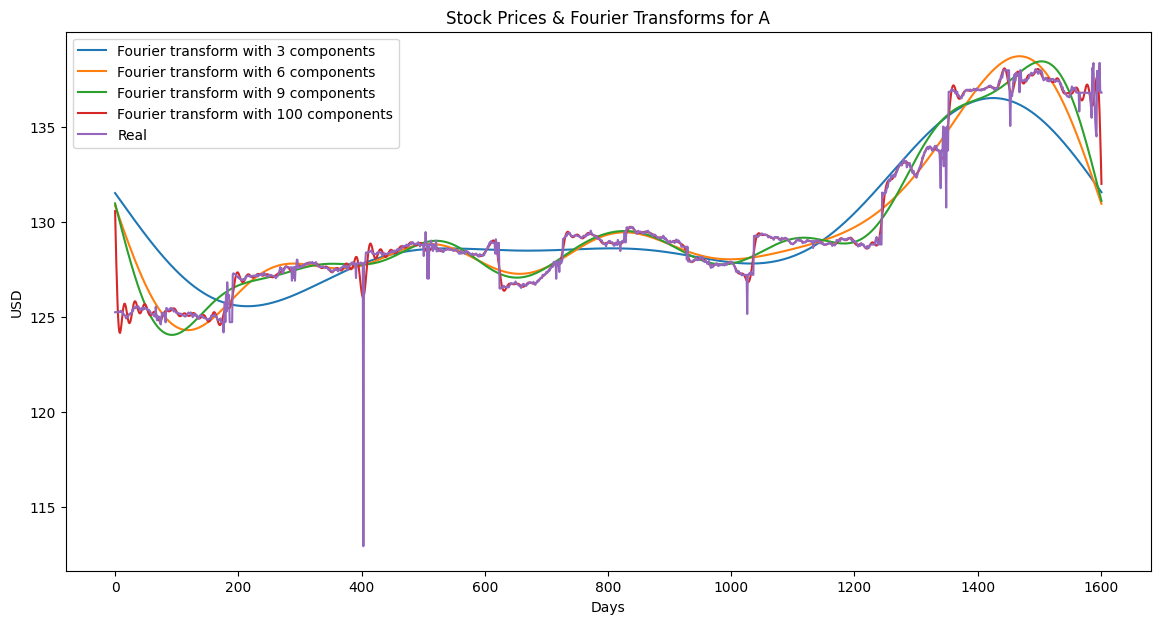

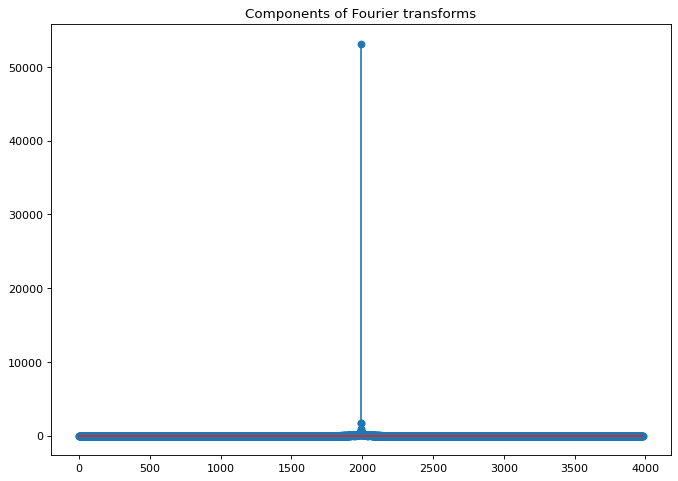

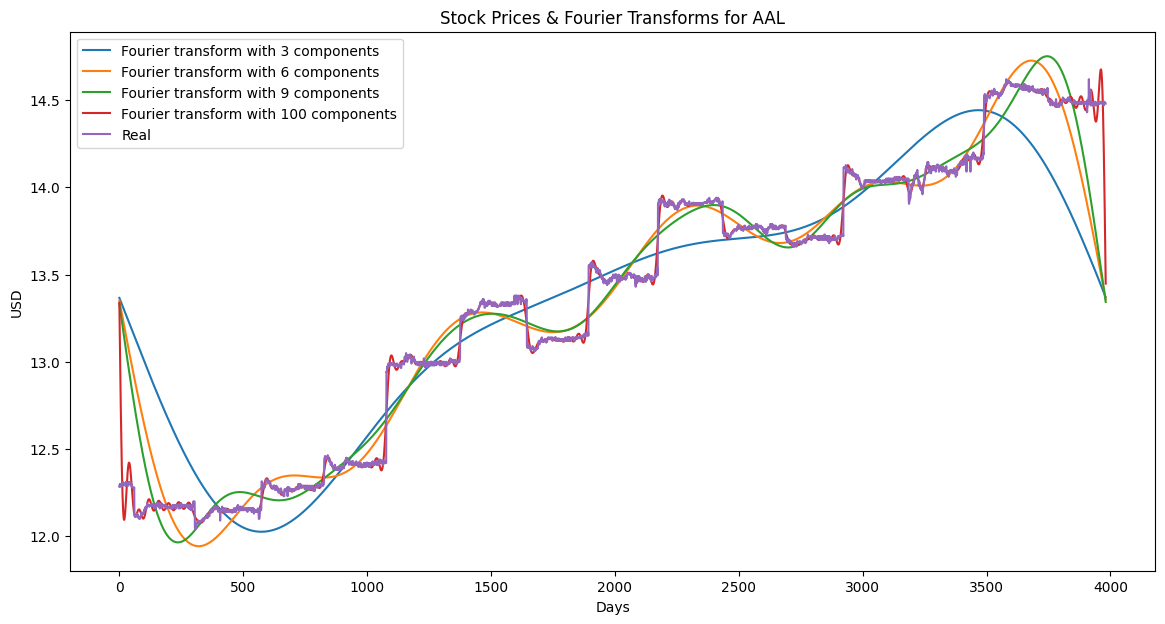

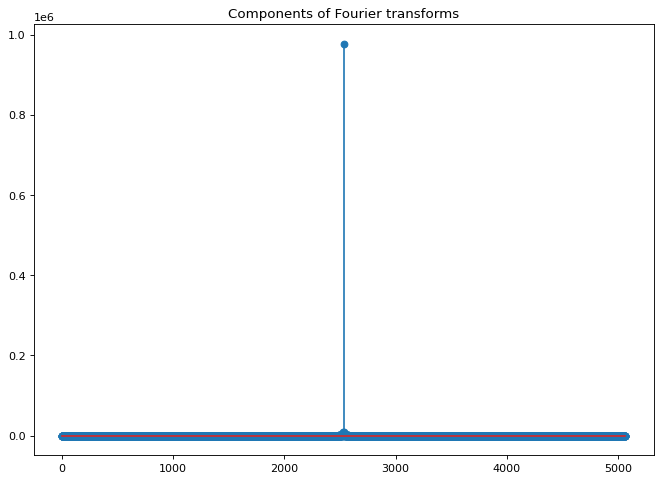

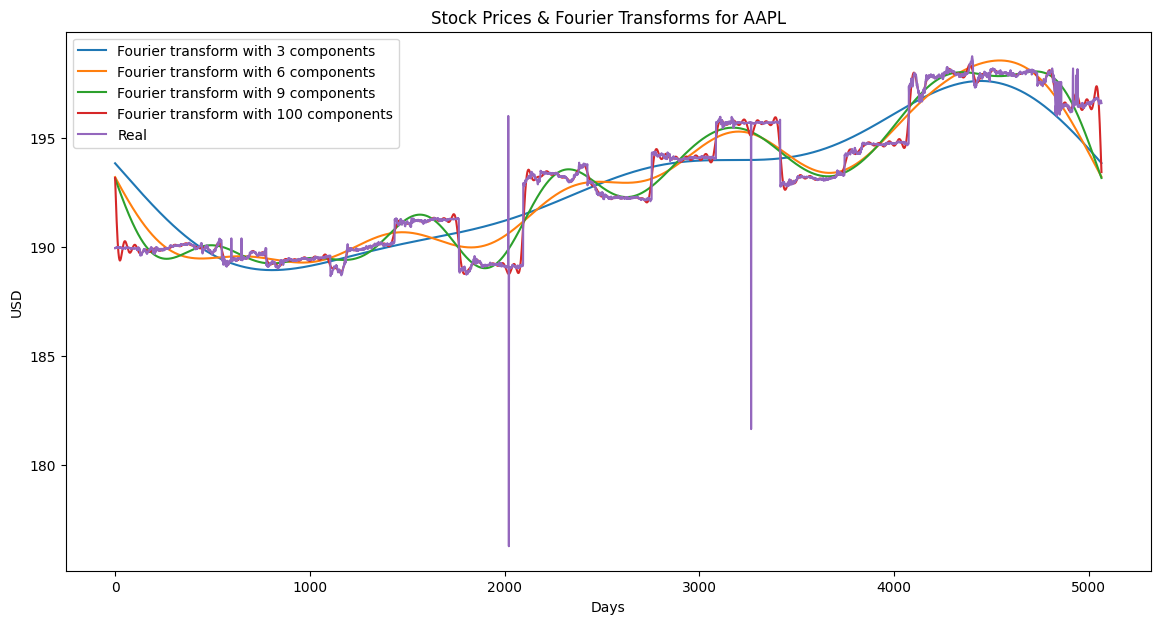

In [11]:

def plot_and_return_fourier_transform(symbol, data, num_components=[3, 6, 9, 100]):
    close_fft = np.fft.fft(np.asarray(data))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = np.abs(fft_df['fft'])

    # Visualize the absolute values of Fourier components
    items = deque(np.asarray(fft_df['absolute'].tolist()))
    items.rotate(int(np.floor(len(fft_df)/2)))
    plt.figure(figsize=(10, 7), dpi=80)
    plt.stem(items)
    plt.title('Components of Fourier transforms')
    plt.show()

    plt.figure(figsize=(14, 7), dpi=100)
    fft_list = np.asarray(fft_df['fft'].tolist())

    fourier_data = {}

    for num in num_components:
        fft_list_m10 = np.copy(fft_list)
        fft_list_m10[num:-num] = 0
        ifft = np.fft.ifft(fft_list_m10).real
        fourier_data[f'fourier_{num}'] = ifft

        plt.plot(ifft, label=f'Fourier transform with {num} components')

    plt.plot(data, label='Real')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title(f'Stock Prices & Fourier Transforms for {symbol}')
    plt.legend()
    plt.show()

    return fourier_data

# Iterate through each unique symbol, plot, and add Fourier components to DataFrame
unique_symbols = combined_data_with_signals['symbol'].unique()
plot_counter = 0

for symbol in unique_symbols:
    symbol_data = combined_data_with_signals[combined_data_with_signals['symbol'] == symbol]
    if len(symbol_data) > 0:
        fourier_data = plot_and_return_fourier_transform(symbol, symbol_data['close'].tolist()) if plot_counter < 3 else None

        # Ensure index alignment and increment counter
        if fourier_data:
            for key, value in fourier_data.items():
                combined_data_with_signals.loc[symbol_data.index, key] = value
            plot_counter += 1

# Handle missing values if necessary
combined_data_with_signals.fillna(0, inplace=True)


**Fitting Arima and Adding it to Dataframe**

In [14]:
def fit_and_forecast_arima(series, symbol):
    # Ensure series is a pandas Series with a default integer index
    series = series.reset_index(drop=True)

    # Splitting data into train and test sets
    size = int(len(series) * 0.66)
    train, test = series.iloc[0:size], series.iloc[size:len(series)]
    history = [x for x in train]
    predictions = []

    # Training ARIMA model and making forecasts
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test.iloc[t])

    # Calculating error
    error = mean_squared_error(test, predictions)
    print(f'\nTest MSE for {symbol}: {error:.3f}')

    # Plotting real vs predicted values
    plt.figure(figsize=(12, 6), dpi=100)
    plt.plot(test, label='Real')
    plt.plot(predictions, color='red', label='Predicted')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title(f'ARIMA model predictions vs Real for {symbol}')
    plt.legend()
    plt.show()

    return predictions, error


def fit_arima_garch(df, symbol):
    # Autocorrelation plot
    autocorrelation_plot(df['close'])
    plt.title(f"Autocorrelation Plot for {symbol}")
    plt.figure(figsize=(10, 7), dpi=80)
    plt.show()

    # ARIMA model
    model_arima = ARIMA(df['close'], order=(5, 1, 0))
    model_arima_fit = model_arima.fit()
    print(f"\nARIMA Model Summary for {symbol}:")
    print(model_arima_fit.summary())

    # GARCH model
    model_garch = arch_model(df['close'], vol='Garch', p=1, q=1)
    model_garch_fit = model_garch.fit(disp='off')

    return model_arima_fit, model_garch_fit

def extract_features(model_arima_fit, model_garch_fit):
    arima_forecast = model_arima_fit.forecast(steps=1).iloc[-1]
    garch_volatility = model_garch_fit.conditional_volatility.iloc[-1]

    return {
        'arima_forecast': arima_forecast,
        'garch_volatility': garch_volatility
    }

# Apply ARIMA-GARCH modeling and ARIMA forecasting for each unique symbol
arima_stats = []
arima_forecast_errors = []

unique_symbols = combined_data_with_signals['symbol'].unique()
for symbol in unique_symbols:
    stock_data = combined_data_with_signals[combined_data_with_signals['symbol'] == symbol]

    # Fit ARIMA-GARCH models
    model_arima_fit, model_garch_fit = fit_arima_garch(stock_data, symbol)
    arima_stats.append([model_arima_fit.aic, model_arima_fit.bic])

    # Extract features
    features = extract_features(model_arima_fit, model_garch_fit)


    # Add the extracted features as new columns to the DataFrame
    for feature_name, value in features.items():
        combined_data_with_signals.loc[combined_data_with_signals['symbol'] == symbol, feature_name] = value

    # Calculate RMSE for ARIMA forecast
    arima_forecast = model_arima_fit.forecast(steps=1).iloc[-1]
    actual_values = stock_data['close'].values

    if len(actual_values) > 0:
        rmse = np.sqrt(mean_squared_error(actual_values[-1:], [arima_forecast]))
        combined_data_with_signals.loc[combined_data_with_signals['symbol'] == symbol, 'arima_rmse'] = rmse

    # ARIMA forecasting on a subset of the data
    predictions, error = fit_and_forecast_arima(stock_data['close'], symbol)
    arima_forecast_errors.append(error)

# Convert ARIMA statistics and forecast errors to DataFrames for aggregation
arima_stats_df = pd.DataFrame(arima_stats, columns=['AIC', 'BIC'])
arima_forecast_errors_df = pd.DataFrame(arima_forecast_errors, columns=['Forecast Error'])

# Aggregate statistics
aggregate_stats = arima_stats_df.mean()
aggregate_forecast_errors = arima_forecast_errors_df.mean()

# Print aggregate ARIMA statistics and forecast errors
print("\nAggregate ARIMA Statistics:")
print(aggregate_stats)
print("\nAggregate ARIMA Forecast Errors:")
print(aggregate_forecast_errors)

# Ensure to fill NaN values if necessary
combined_data_with_signals.fillna(0, inplace=True)


NameError: ignored

**Getting Sentiment data**

In [13]:
API_KEY = 'Q8WVI3I6NTBSKAZQ'
FUNCTION = 'NEWS_SENTIMENT'
ticker = 'MSFT'
url = f'https://www.alphavantage.co/query?function={FUNCTION}&apikey={API_KEY}'
response = requests.get(url)
sentiment_data = response.json()
# Extracting the 'ticker_sentiment' column from the 'feed' list
ticker_sentiment = [item['ticker_sentiment'] for item in sentiment_data['feed']]

flattened_data = [item for sublist in ticker_sentiment for item in sublist]

sentiment_df = pd.DataFrame(flattened_data)

sentiment_df.columns = ['ticker', 'relevance_score', 'ticker_sentiment_score', 'ticker_sentiment_label']

print(sentiment_df)

        ticker relevance_score ticker_sentiment_score ticker_sentiment_label
0           EA        0.396052               0.145083                Neutral
1         WFHG        0.050894                    0.0                Neutral
2         NVDA        0.399204               0.459628                Bullish
3         ROKU        0.399204              -0.271094       Somewhat-Bearish
4            C        0.138464              -0.221265       Somewhat-Bearish
..         ...             ...                    ...                    ...
89          GM        0.227007              -0.178946       Somewhat-Bearish
90  CRYPTO:BTC        0.550532               0.199011       Somewhat-Bullish
91        TRMB        0.040691               0.068785                Neutral
92        GOOG        0.040691                 0.0972                Neutral
93       NTDOF         0.13873               0.284422       Somewhat-Bullish

[94 rows x 4 columns]


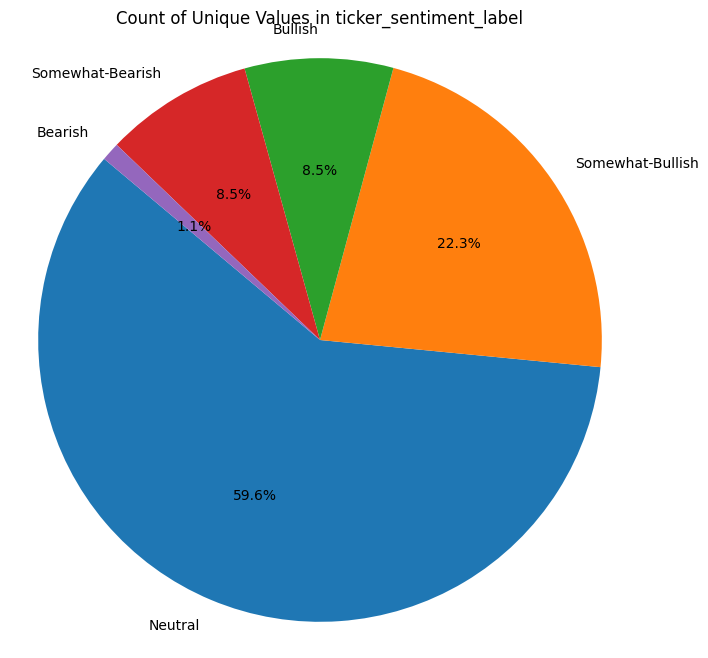

In [15]:

# Calculate value counts for the column
value_counts = sentiment_df['ticker_sentiment_label'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(8, 8))  # Set the figure size

# Creating the pie chart
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Title of the pie chart
plt.title('Count of Unique Values in ticker_sentiment_label')

# Show the pie chart
plt.show()


**Merging Data frames**

In [16]:
# Merge the DataFrames based on 'ticker' and 'symbol'
merged_df = pd.merge(combined_data_with_signals, sentiment_df, left_on='symbol', right_on='ticker', how='left')
merged_df.drop('ticker', axis=1, inplace=True)
merged_df.head()


,open,high,low,close,volume,symbol,RSI,MACD,MACD_Hist,MACD_Signal,...,fourier_3,fourier_6,fourier_9,fourier_100,arima_forecast,garch_volatility,arima_rmse,relevance_score,ticker_sentiment_score,ticker_sentiment_label
0,125.240,125.24,125.215,125.230,2101.0,A,34.817791,-0.183684,0.036939,-0.220623,...,131.499821,130.842535,130.955836,130.550084,136.95105,7.884464,0.17105,NaN,NaN,NaN
1,125.220,125.23,125.220,125.225,2073.0,A,34.579283,-0.175299,0.036260,-0.211558,...,131.454453,130.748894,130.827544,129.133559,136.95105,7.884464,0.17105,NaN,NaN,NaN
2,125.225,125.25,125.210,125.250,2757.0,A,36.906520,-0.164737,0.037457,-0.202194,...,131.409070,130.655374,130.699388,127.805610,136.95105,7.884464,0.17105,NaN,NaN,NaN
3,125.250,125.25,125.210,125.240,1549.0,A,36.349503,-0.155382,0.037449,-0.192832,...,131.363675,130.561993,130.571414,126.630490,136.95105,7.884464,0.17105,NaN,NaN,NaN
4,125.250,125.28,125.245,125.245,5678.0,A,36.862608,-0.145884,0.037558,-0.183442,...,131.318272,130.468769,130.443669,125.658620,136.95105,7.884464,0.17105,NaN,NaN,NaN


In [17]:
merged_df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'symbol', 'RSI', 'MACD',
       'MACD_Hist', 'MACD_Signal', 'BB_Lower', 'BB_Middle', 'BB_Upper',
       'KCLe_20_2_old', 'KCBe_20_2_old', 'KCUe_20_2_old', 'EMA_12', 'EMA_26',
       'Stoch_K', 'Stoch_D', 'ATR', 'ADX', 'Momentum', 'RSI_Signal_Buy',
       'RSI_Signal_Sell', 'MACD_Signal_Buy', 'MACD_Signal_Sell',
       'BB_Signal_Buy', 'BB_Signal_Sell', 'KC_Signal_Buy', 'KC_Signal_Sell',
       'Stoch_Signal_Buy', 'Stoch_Signal_Sell', 'EMA_Signal_Buy',
       'EMA_Signal_Sell', 'fourier_3', 'fourier_6', 'fourier_9', 'fourier_100',
       'arima_forecast', 'garch_volatility', 'arima_rmse', 'relevance_score',
       'ticker_sentiment_score', 'ticker_sentiment_label'],
      dtype='object')

In [18]:
merged_df.dtypes

open                      float64
high                      float64
low                       float64
close                     float64
volume                    float64
symbol                     object
RSI                       float64
MACD                      float64
MACD_Hist                 float64
MACD_Signal               float64
BB_Lower                  float64
BB_Middle                 float64
BB_Upper                  float64
KCLe_20_2_old             float64
KCBe_20_2_old             float64
KCUe_20_2_old             float64
EMA_12                    float64
EMA_26                    float64
Stoch_K                   float64
Stoch_D                   float64
ATR                       float64
ADX                       float64
Momentum                  float64
RSI_Signal_Buy              int64
RSI_Signal_Sell             int64
MACD_Signal_Buy             int64
MACD_Signal_Sell            int64
BB_Signal_Buy               int64
BB_Signal_Sell              int64
KC_Signal_Buy 

In [21]:
dataset_total_df =merged_df

**Label encodeing the Categorical variables**

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
merged_df['symbol'] = label_encoder.fit_transform(merged_df['symbol'])
merged_df['ticker_sentiment_label'] = label_encoder.fit_transform(merged_df['ticker_sentiment_label'])

**Checking Feature Importance using XGboost**

In [23]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['close']
    X = data.iloc[:, 1:]

    train_samples = int(X.shape[0] * 0.65)

    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]

    return (X_train, y_train), (X_test, y_test)

# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(merged_df)

In [24]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

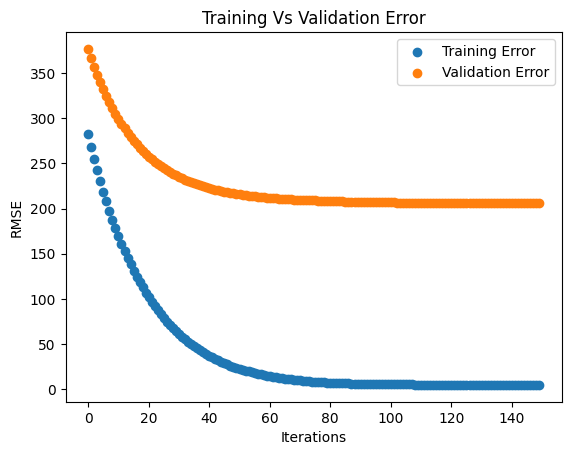

In [25]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

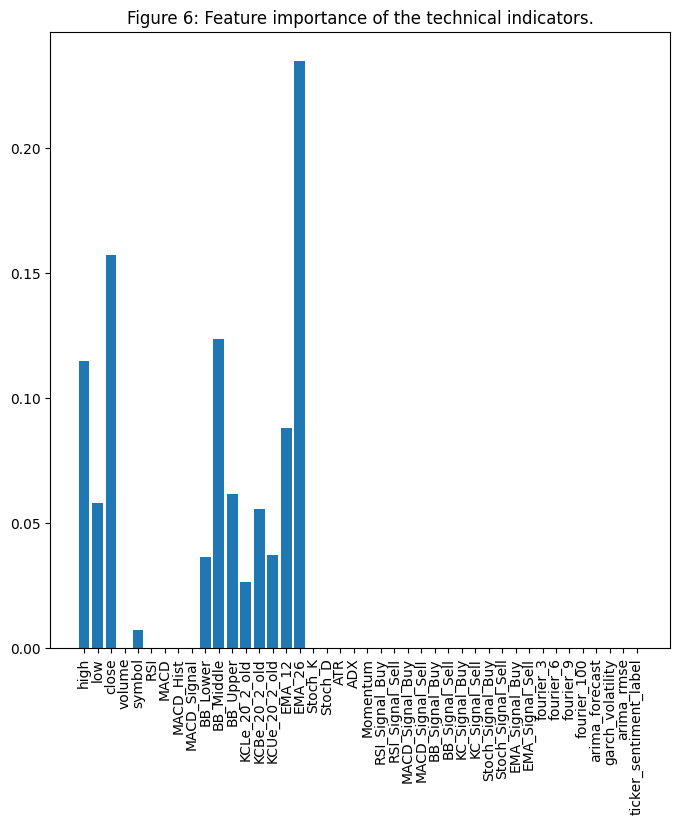

In [26]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

In [27]:
merged_df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'symbol', 'RSI', 'MACD',
       'MACD_Hist', 'MACD_Signal', 'BB_Lower', 'BB_Middle', 'BB_Upper',
       'KCLe_20_2_old', 'KCBe_20_2_old', 'KCUe_20_2_old', 'EMA_12', 'EMA_26',
       'Stoch_K', 'Stoch_D', 'ATR', 'ADX', 'Momentum', 'RSI_Signal_Buy',
       'RSI_Signal_Sell', 'MACD_Signal_Buy', 'MACD_Signal_Sell',
       'BB_Signal_Buy', 'BB_Signal_Sell', 'KC_Signal_Buy', 'KC_Signal_Sell',
       'Stoch_Signal_Buy', 'Stoch_Signal_Sell', 'EMA_Signal_Buy',
       'EMA_Signal_Sell', 'fourier_3', 'fourier_6', 'fourier_9', 'fourier_100',
       'arima_forecast', 'garch_volatility', 'arima_rmse',
       'ticker_sentiment_label'],
      dtype='object')

Let's visualize GELU, ReLU, and LeakyReLU (the last one is mainly used in GANs - we also use it).

In [30]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

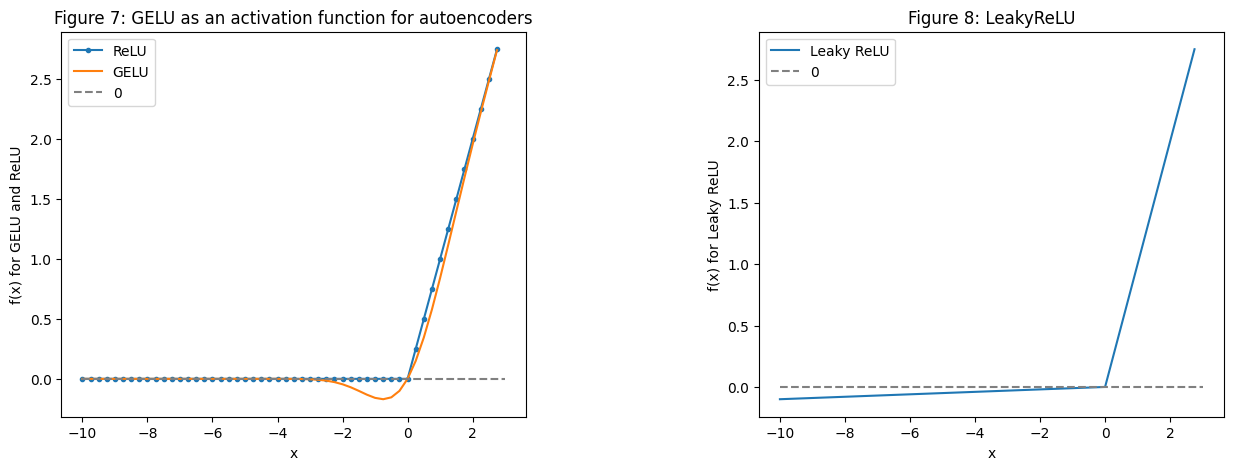

In [34]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()

plt.show()

**Eigen portfolio with PCA**

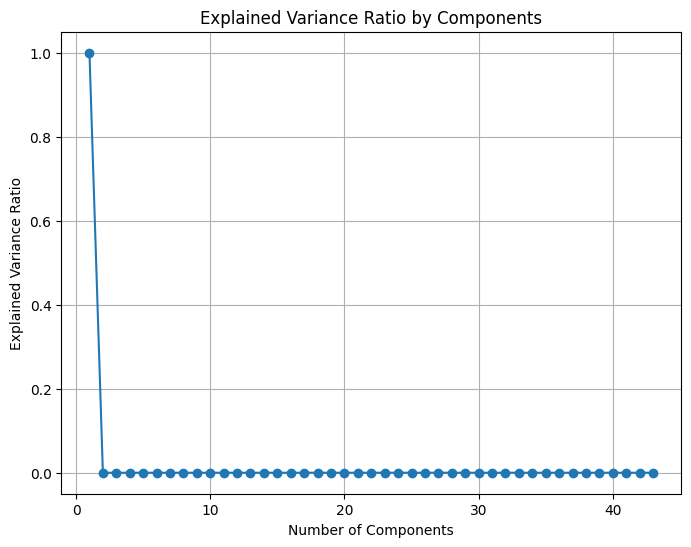

Eigen Portfolios:
                        Eigenportfolio_1  Eigenportfolio_2
open                        2.050223e-06     -2.414432e-01
high                        2.056914e-06     -2.415253e-01
low                         2.042776e-06     -2.413512e-01
close                       2.052114e-06     -2.414398e-01
volume                      1.000000e+00      8.499743e-06
symbol                      1.980128e-08     -1.183040e-03
RSI                         7.393081e-08      8.761062e-04
MACD                       -4.490373e-10     -1.093633e-05
MACD_Hist                  -1.360184e-10      5.951942e-08
MACD_Signal                -3.130189e-10     -1.099585e-05
BB_Lower                    2.043567e-06     -2.413040e-01
BB_Middle                   2.052464e-06     -2.414366e-01
BB_Upper                    2.061360e-06     -2.415693e-01
KCLe_20_2_old               2.044185e-06     -2.410414e-01
KCBe_20_2_old               2.052954e-06     -2.414250e-01
KCUe_20_2_old               2.061724e-

In [36]:

# Perform PCA
pca = PCA()
merged_df.dropna(inplace=True)
pca.fit(merged_df)

# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Components')
plt.grid(True)
plt.show()

# Choose the number of components (e.g., based on the plot or domain knowledge)
num_components = 2  # Example: Choosing 2 components

# Fit PCA with the chosen number of components
pca = PCA(n_components=num_components)
pca.fit(merged_df)

# Get the loadings (eigenvectors)
loadings = pca.components_

# Create the Eigen portfolios
eigen_portfolios = pd.DataFrame(loadings.T, columns=[f'Eigenportfolio_{i+1}' for i in range(num_components)], index=merged_df.columns)

# Print or use eigen_portfolios for analysis
print("Eigen Portfolios:")
print(eigen_portfolios)


In [37]:
dataset_total_df = merged_df

In [38]:
dataset_total_df.head()

,open,high,low,close,volume,symbol,RSI,MACD,MACD_Hist,MACD_Signal,...,EMA_Signal_Buy,EMA_Signal_Sell,fourier_3,fourier_6,fourier_9,fourier_100,arima_forecast,garch_volatility,arima_rmse,ticker_sentiment_label
0,125.240,125.24,125.215,125.230,2101.0,0,34.817791,-0.183684,0.036939,-0.220623,...,False,True,131.499821,130.842535,130.955836,130.550084,136.95105,7.884464,0.17105,4
1,125.220,125.23,125.220,125.225,2073.0,0,34.579283,-0.175299,0.036260,-0.211558,...,False,True,131.454453,130.748894,130.827544,129.133559,136.95105,7.884464,0.17105,4
2,125.225,125.25,125.210,125.250,2757.0,0,36.906520,-0.164737,0.037457,-0.202194,...,False,True,131.409070,130.655374,130.699388,127.805610,136.95105,7.884464,0.17105,4
3,125.250,125.25,125.210,125.240,1549.0,0,36.349503,-0.155382,0.037449,-0.192832,...,False,True,131.363675,130.561993,130.571414,126.630490,136.95105,7.884464,0.17105,4
4,125.250,125.28,125.245,125.245,5678.0,0,36.862608,-0.145884,0.037558,-0.183442,...,False,True,131.318272,130.468769,130.443669,125.658620,136.95105,7.884464,0.17105,4


In [39]:
dataset_total_df['ticker_sentiment_label'].unique()


array([4])

In [40]:
dataset_total_df['ticker_sentiment_label'].fillna('Neutral', inplace=True)

In [41]:
dataset_total_df.dtypes

open                      float64
high                      float64
low                       float64
close                     float64
volume                    float64
symbol                      int64
RSI                       float64
MACD                      float64
MACD_Hist                 float64
MACD_Signal               float64
BB_Lower                  float64
BB_Middle                 float64
BB_Upper                  float64
KCLe_20_2_old             float64
KCBe_20_2_old             float64
KCUe_20_2_old             float64
EMA_12                    float64
EMA_26                    float64
Stoch_K                   float64
Stoch_D                   float64
ATR                       float64
ADX                       float64
Momentum                  float64
RSI_Signal_Buy              int64
RSI_Signal_Sell             int64
MACD_Signal_Buy             int64
MACD_Signal_Sell            int64
BB_Signal_Buy               int64
BB_Signal_Sell              int64
KC_Signal_Buy 

In [43]:
dataset_total_df.select_dtypes(exclude=['float', 'int']).columns.tolist()


['EMA_Signal_Buy', 'EMA_Signal_Sell']

In [44]:
from sklearn.preprocessing import LabelEncoder
from joblib import dump

non_numeric_columns = dataset_total_df.select_dtypes(exclude=['float', 'int']).columns.tolist()

encoders = {}

for col in non_numeric_columns:
    label_encoder = LabelEncoder()
    dataset_total_df[col] = label_encoder.fit_transform(dataset_total_df[col])
    encoders[col] = label_encoder

# for col, encoder in encoders.items():
#     dump(encoder, f'{col}_encoder.joblib')


In [45]:
dataset_total_df

,open,high,low,close,volume,symbol,RSI,MACD,MACD_Hist,MACD_Signal,...,EMA_Signal_Buy,EMA_Signal_Sell,fourier_3,fourier_6,fourier_9,fourier_100,arima_forecast,garch_volatility,arima_rmse,ticker_sentiment_label
0,125.240,125.24,125.215,125.230,2101.0,0,34.817791,-0.183684,0.036939,-0.220623,...,0,1,131.499821,130.842535,130.955836,130.550084,136.951050,7.884464,0.171050,4
1,125.220,125.23,125.220,125.225,2073.0,0,34.579283,-0.175299,0.036260,-0.211558,...,0,1,131.454453,130.748894,130.827544,129.133559,136.951050,7.884464,0.171050,4
2,125.225,125.25,125.210,125.250,2757.0,0,36.906520,-0.164737,0.037457,-0.202194,...,0,1,131.409070,130.655374,130.699388,127.805610,136.951050,7.884464,0.171050,4
3,125.250,125.25,125.210,125.240,1549.0,0,36.349503,-0.155382,0.037449,-0.192832,...,0,1,131.363675,130.561993,130.571414,126.630490,136.951050,7.884464,0.171050,4
4,125.250,125.28,125.245,125.245,5678.0,0,36.862608,-0.145884,0.037558,-0.183442,...,0,1,131.318272,130.468769,130.443669,125.658620,136.951050,7.884464,0.171050,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12890,154.190,154.19,154.190,154.190,1.0,3,50.649908,-0.046688,0.006764,-0.053453,...,1,0,0.000000,0.000000,0.000000,0.000000,154.138125,9.620028,0.051875,4
12891,154.050,154.05,154.050,154.050,2.0,3,48.113619,-0.047748,0.004564,-0.052312,...,0,1,0.000000,0.000000,0.000000,0.000000,154.138125,9.620028,0.051875,4
12892,154.040,154.04,154.040,154.040,1.0,3,47.929000,-0.048831,0.002784,-0.051615,...,0,1,0.000000,0.000000,0.000000,0.000000,154.138125,9.620028,0.051875,4
12893,154.040,154.04,154.040,154.040,39.0,3,47.929000,-0.049123,0.001994,-0.051117,...,0,1,0.000000,0.000000,0.000000,0.000000,154.138125,9.620028,0.051875,4


In [46]:
nan_counts = dataset_total_df.isna().sum()

print(nan_counts)

open                      0
high                      0
low                       0
close                     0
volume                    0
symbol                    0
RSI                       0
MACD                      0
MACD_Hist                 0
MACD_Signal               0
BB_Lower                  0
BB_Middle                 0
BB_Upper                  0
KCLe_20_2_old             0
KCBe_20_2_old             0
KCUe_20_2_old             0
EMA_12                    0
EMA_26                    0
Stoch_K                   0
Stoch_D                   0
ATR                       0
ADX                       0
Momentum                  0
RSI_Signal_Buy            0
RSI_Signal_Sell           0
MACD_Signal_Buy           0
MACD_Signal_Sell          0
BB_Signal_Buy             0
BB_Signal_Sell            0
KC_Signal_Buy             0
KC_Signal_Sell            0
Stoch_Signal_Buy          0
Stoch_Signal_Sell         0
EMA_Signal_Buy            0
EMA_Signal_Sell           0
fourier_3           

In [47]:
dataset_total_df.dtypes

open                      float64
high                      float64
low                       float64
close                     float64
volume                    float64
symbol                      int64
RSI                       float64
MACD                      float64
MACD_Hist                 float64
MACD_Signal               float64
BB_Lower                  float64
BB_Middle                 float64
BB_Upper                  float64
KCLe_20_2_old             float64
KCBe_20_2_old             float64
KCUe_20_2_old             float64
EMA_12                    float64
EMA_26                    float64
Stoch_K                   float64
Stoch_D                   float64
ATR                       float64
ADX                       float64
Momentum                  float64
RSI_Signal_Buy              int64
RSI_Signal_Sell             int64
MACD_Signal_Buy             int64
MACD_Signal_Sell            int64
BB_Signal_Buy               int64
BB_Signal_Sell              int64
KC_Signal_Buy 

**Taking Smaller No of Rows due to Processing Constrains**

In [48]:
dataset = dataset_total_df
new_df = dataset.iloc[-200000:]
dataset = new_df

**Prepareing Data for WGAN-GP Prediction**

Index(['open', 'high', 'low', 'close', 'volume', 'symbol', 'RSI', 'MACD',
       'MACD_Hist', 'MACD_Signal', 'BB_Lower', 'BB_Middle', 'BB_Upper',
       'KCLe_20_2_old', 'KCBe_20_2_old', 'KCUe_20_2_old', 'EMA_12', 'EMA_26',
       'Stoch_K', 'Stoch_D', 'ATR', 'ADX', 'Momentum', 'RSI_Signal_Buy',
       'RSI_Signal_Sell', 'MACD_Signal_Buy', 'MACD_Signal_Sell',
       'BB_Signal_Buy', 'BB_Signal_Sell', 'KC_Signal_Buy', 'KC_Signal_Sell',
       'Stoch_Signal_Buy', 'Stoch_Signal_Sell', 'EMA_Signal_Buy',
       'EMA_Signal_Sell', 'fourier_3', 'fourier_6', 'fourier_9', 'fourier_100',
       'arima_forecast', 'garch_volatility', 'arima_rmse',
       'ticker_sentiment_label'],
      dtype='object')
(12895, 43) (12895, 1)


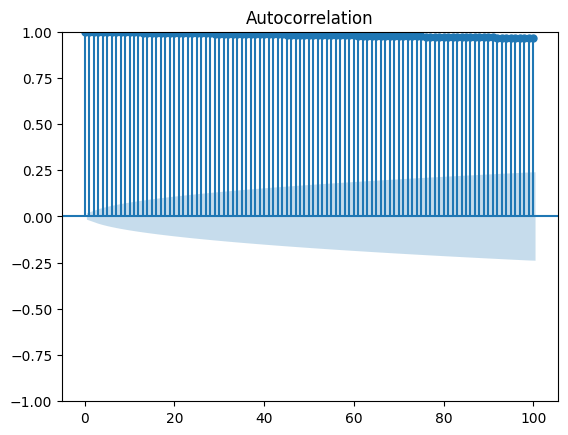

X shape:  (12892, 3, 43)
y shape:  (12892, 1)
X_train shape:  (10314, 3, 43)
y_train shape:  (10314, 1)
y_c_train shape:  (10314, 3, 1)
X_test shape:  (2578, 3, 43)
y_test shape:  (2578, 1)
y_c_test shape:  (2578, 3, 1)
index_train shape: (10314,)
index_test shape: (2578,)


In [49]:

dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill(), dataset.iloc[:, 1:].bfill()]).groupby(level=0).mean()
print(dataset.columns)

# Get features and target
X_value = pd.DataFrame(dataset.iloc[:, :])
y_value = pd.DataFrame(dataset.iloc[:, 3])
print(X_value.shape,y_value.shape)
# Autocorrelation Check
sm.graphics.tsa.plot_acf(y_value.squeeze(), lags=100)
plt.show()
# Normalized the data
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler.fit(X_value)
y_scaler.fit(y_value)

X_scale_dataset = X_scaler.fit_transform(X_value)
y_scale_dataset = y_scaler.fit_transform(y_value)

dump(X_scaler, open('X_scaler.pkl', 'wb'))
dump(y_scaler, open('y_scaler.pkl', 'wb'))



# Reshape the data
'''Set the data input steps and output steps,
    we use 30 days data to predict 1 day price here,
    reshape it to (None, input_step, number of features) used for LSTM input'''
n_steps_in = 3
n_features = X_value.shape[1]
n_steps_out = 1

# Get X/y dataset
def get_X_y(X_data, y_data):
    X = list()
    y = list()
    yc = list()

    length = len(X_data)
    for i in range(0, length, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        yc_value = y_data[i: i + n_steps_in][:, :]
        if len(X_value) == 3 and len(y_value) == 1:
            X.append(X_value)
            y.append(y_value)
            yc.append(yc_value)

    return np.array(X), np.array(y), np.array(yc)

# get the train test predict index
def predict_index(dataset, X_train, n_steps_in, n_steps_out):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index

    return train_predict_index, test_predict_index

# Split train/test dataset
def split_train_test(data):
    train_size = round(len(X) * 0.8)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

X, y, yc = get_X_y(X_scale_dataset, y_scale_dataset)
X_train, X_test, = split_train_test(X)
y_train, y_test, = split_train_test(y)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, n_steps_in, n_steps_out)
# %% --------------------------------------- Save dataset -----------------------------------------------------------------
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('y_c_train shape: ', yc_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('y_c_test shape: ', yc_test.shape)
print('index_train shape:', index_train.shape)
print('index_test shape:', index_test.shape)


**WGAN-GP Prediction**

epoch 15 d_loss 9.128666 g_loss 0.057288777


epoch 30 d_loss 8.09146 g_loss 0.124140985


epoch 45 d_loss 6.613271 g_loss 0.24014236


epoch 60 d_loss 4.590965 g_loss 0.42566592


epoch 75 d_loss 2.1909294 g_loss 0.7163009


epoch 90 d_loss 0.74755603 g_loss 1.0589465


epoch 105 d_loss 0.277467 g_loss 1.1855469


epoch 120 d_loss 0.08876265 g_loss 1.1406671


epoch 135 d_loss 0.023169963 g_loss 1.1274624


epoch 150 d_loss -0.008747958 g_loss 1.1284645


epoch 165 d_loss -0.033570945 g_loss 1.1276926


epoch 180 d_loss 0.030585788 g_loss 1.0568392


epoch 195 d_loss 0.0074116453 g_loss 1.0272661


epoch 210 d_loss 0.0047165677 g_loss 1.0316821


epoch 225 d_loss 0.0033426546 g_loss 1.0363963


epoch 240 d_loss 0.004525626 g_loss 1.0434204


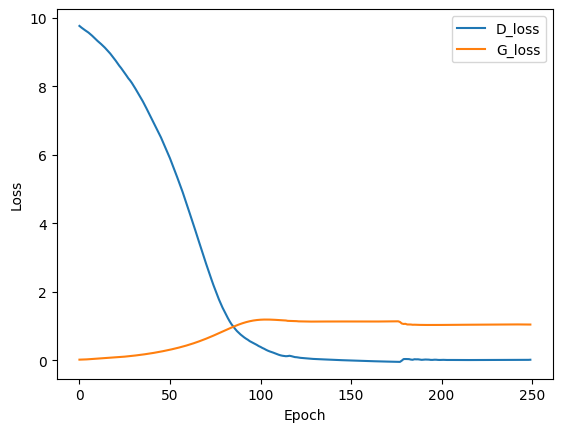

REAL (10314, 1)
[[0.21256722]
 [0.21262078]
 [0.21256722]
 ...
 [0.99196606]
 [0.99196606]
 [0.99207318]]
PREDICTED (10314, 1)
[[0.22573741]
 [0.22219832]
 [0.22047935]
 ...
 [0.97977877]
 [0.97695655]
 [0.97554946]]


<Figure size 640x480 with 0 Axes>

In [51]:
from tensorflow.keras import regularizers

# Define the generator
def Generator(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(GRU(units=256,
                  return_sequences=True,
                  input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.02,
                  recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(GRU(units=128,
                  #return_sequences=True,
                  recurrent_dropout=0.02,
                  recurrent_regularizer=regularizers.l2(1e-3)))
    #model.add(Dense(128,
    #              kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(64, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-3)))
    #model.add(Dense(16, kernel_regularizer=regularizers.l2(1e-3)))
    #model.add(Dense(8, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(units=output_dim))
    return model

# Define the discriminator
def Discriminator() -> tf.keras.models.Model:
    model = tf.keras.Sequential()
    model.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(64, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(128, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Flatten())
    model.add(Dense(220, use_bias=True))
    model.add(LeakyReLU())
    model.add(Dense(220, use_bias=True))
    model.add(ReLU())
    model.add(Dense(1))
    return model

# Train WGAN-GP model
class GAN():
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.d_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.g_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = 128
        checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.g_optimizer,
                                              discriminator_optimizer=self.d_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)

    def gradient_penalty(self, batch_size, real_output, fake_output):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interpolated data
        alpha = tf.random.normal([batch_size, 4, 1], 0.0, 1.0)
        diff = fake_output - tf.cast(real_output, tf.float32)
        interpolated = tf.cast(real_output, tf.float32) + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]

        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))

        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_input, real_price, yc = data
        batch_size = tf.shape(real_input)[0]
        for _ in range(1):
            with tf.GradientTape() as d_tape:
                # Train the discriminator
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                real_y_reshape = tf.reshape(real_price, [real_price.shape[0], real_price.shape[1], 1])
                real_output = tf.concat([tf.cast(real_y_reshape, tf.float32), tf.cast(yc, tf.float32)], axis=1)
                # Get the logits for the fake images
                D_real = self.discriminator(real_output, training=True)
                # Get the logits for real images
                D_fake = self.discriminator(fake_output, training=True)
                # Calculate discriminator loss using fake and real logits
                real_loss = tf.cast(tf.reduce_mean(D_real), tf.float32)
                fake_loss = tf.cast(tf.reduce_mean(D_fake), tf.float32)
                d_cost = fake_loss-real_loss
                # Calculate the gradientjiu penalty
                gp = self.gradient_penalty(batch_size, real_output, fake_output)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * 10

            d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        for _ in range(3):
            with tf.GradientTape() as g_tape:
                # Train the generator
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                # Get the discriminator logits for fake images
                G_fake = self.discriminator(fake_output, training=True)
                # Calculate the generator loss
                g_loss = -tf.reduce_mean(G_fake)
            g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return real_price, generated_data, {'d_loss': d_loss, 'g_loss': g_loss}

    def train(self, X_train, y_train, yc, epochs):
        data = X_train, y_train, yc
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []


        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(data)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price)
            Real_price.append(real_price)

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                tf.keras.models.save_model(generator, 'gen_GRU_model_%d.h5' % epoch)
                self.checkpoint.save(file_prefix=self.checkpoint_prefix)
                print('epoch', epoch+1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())

            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)

        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        # Plot the loss
        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.savefig('train_loss.png')

        print("REAL", Real_price.shape)
        print(Real_price)
        print("PREDICTED", Predicted_price.shape)
        print(Predicted_price)

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

if __name__ == '__main__':
    input_dim = X_train.shape[1]
    feature_size = X_train.shape[2]
    output_dim = y_train.shape[1]
    epoch = 250

    generator = Generator(X_train.shape[1], output_dim, X_train.shape[2])
    discriminator = Discriminator()
    gan = GAN(generator, discriminator)
    Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, epoch)


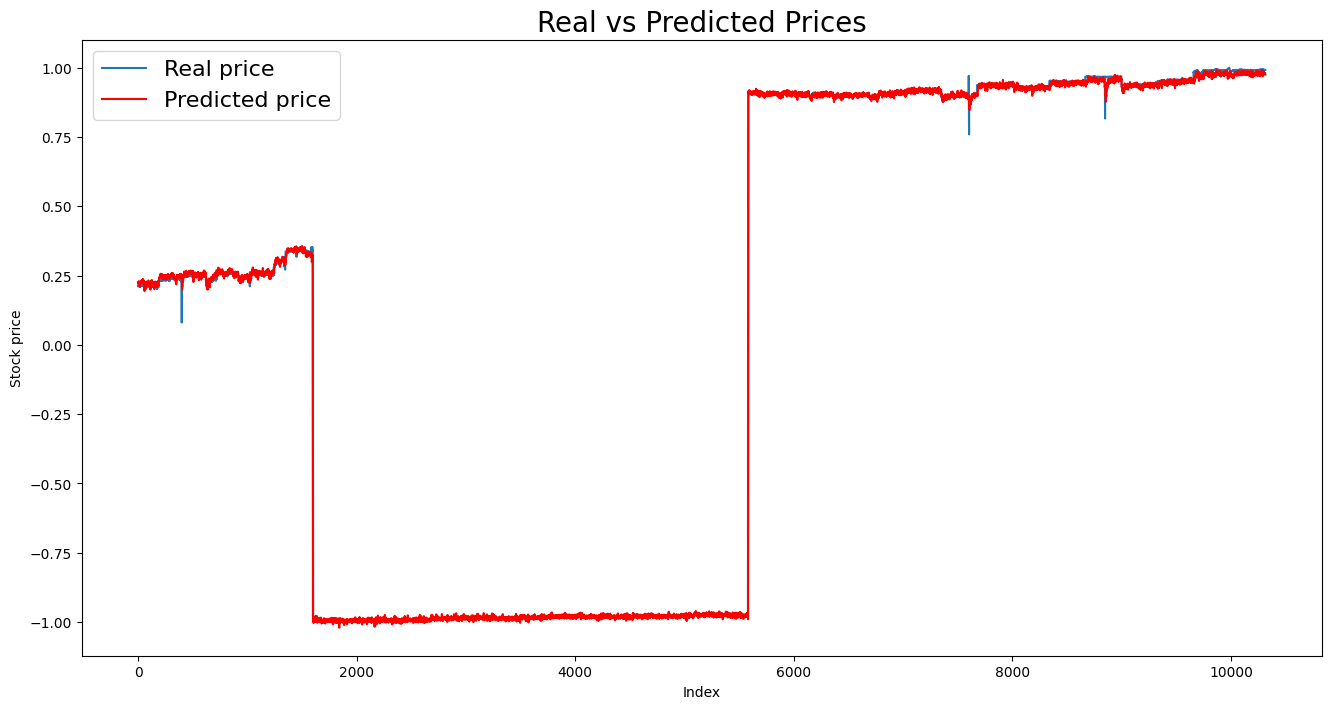

RMSE: [0.14893731 0.10830919 0.08947577 ... 0.13782208 0.16973762 0.18686116]


In [52]:

Real_res, predicted_res, RMSE = Real_price, Predicted_price, RMSPE

# Plot the Real_res and predicted_res
plt.figure(figsize=(16, 8))
plt.plot(Real_res, label='Real price')
plt.plot(predicted_res, color='r', label='Predicted price')
plt.xlabel("Index")
plt.ylabel("Stock price")
plt.legend(loc="upper left", fontsize=16)
plt.title("Real vs Predicted Prices", fontsize=20)
plt.show()

# Display RMSE
print('RMSE:', RMSE)


**Hyper Parameter Optimzation Code**

In [52]:
# Define a grid of hyperparameters to search
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [64, 128, 256],
    'gru_units': [128, 256, 512],
    'optimizer': ['adam', 'rmsprop']
    # Add more hyperparameters to search and their respective values
}

# Create a list of hyperparameter combinations from the grid
param_combinations = list(ParameterGrid(param_grid))

best_RMSPE = float('inf')
best_params = None

# Iterate through each combination of hyperparameters
for params in param_combinations:
    # Update the GAN with the current set of hyperparameters
    generator = Generator(X_train.shape[1], output_dim, X_train.shape[2])
    discriminator = Discriminator()
    gan = GAN(generator, discriminator)

    # Set the hyperparameters
    gan.d_optimizer = tf.keras.optimizers.get(params['optimizer'], learning_rate=params['learning_rate'])
    gan.g_optimizer = tf.keras.optimizers.get(params['optimizer'], learning_rate=params['learning_rate'])
    gan.batch_size = params['batch_size']

    # Train the GAN with the updated hyperparameters
    Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, epoch)

    # Check if current RMSPE is the best so far
    if RMSPE < best_RMSPE:
        best_RMSPE = RMSPE
        best_params = params

print("Best RMSPE:", best_RMSPE)
print("Best hyperparameters:", best_params)


**Portfolio To Sell or Buy**

In [54]:
new_input = X_train[-5:]  # Get the last 5 elements of the NumPy array


In [57]:
G_model = tf.keras.models.load_model('/content/gen_GRU_model_104.h5')
y_predicted = G_model(X_test)
Check_value = X_train[-1:]
Check_value = Check_value[:, :, 2]
predict = y_predicted.mean()
if predict < Check_value:
  Signal = "Sell"
else:
    Signal = 'Buy'
print(Signal)

(1, 3, 43)